## Convert Fashion MNIST to Time Series

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from keras.datasets import fashion_mnist

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 0. Data Preparation

#### Dataset Size

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
print("Shape: {}".format(x_train.shape))

Shape: (60000, 28, 28)


#### Getting data sample

In [4]:
sample_idx = np.arange(x_train.shape[0])
np.random.shuffle(sample_idx)

x_train_small = x_train[sample_idx[:10000]]
y_train_small = y_train[sample_idx[:10000]]

sample_idx = np.arange(x_test.shape[0])
np.random.shuffle(sample_idx)

x_test_small = x_test[sample_idx[:1000]]
y_test_small = y_test[sample_idx[:1000]]

In [5]:
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
labels_map = { k:v for k,v in enumerate(labels) }

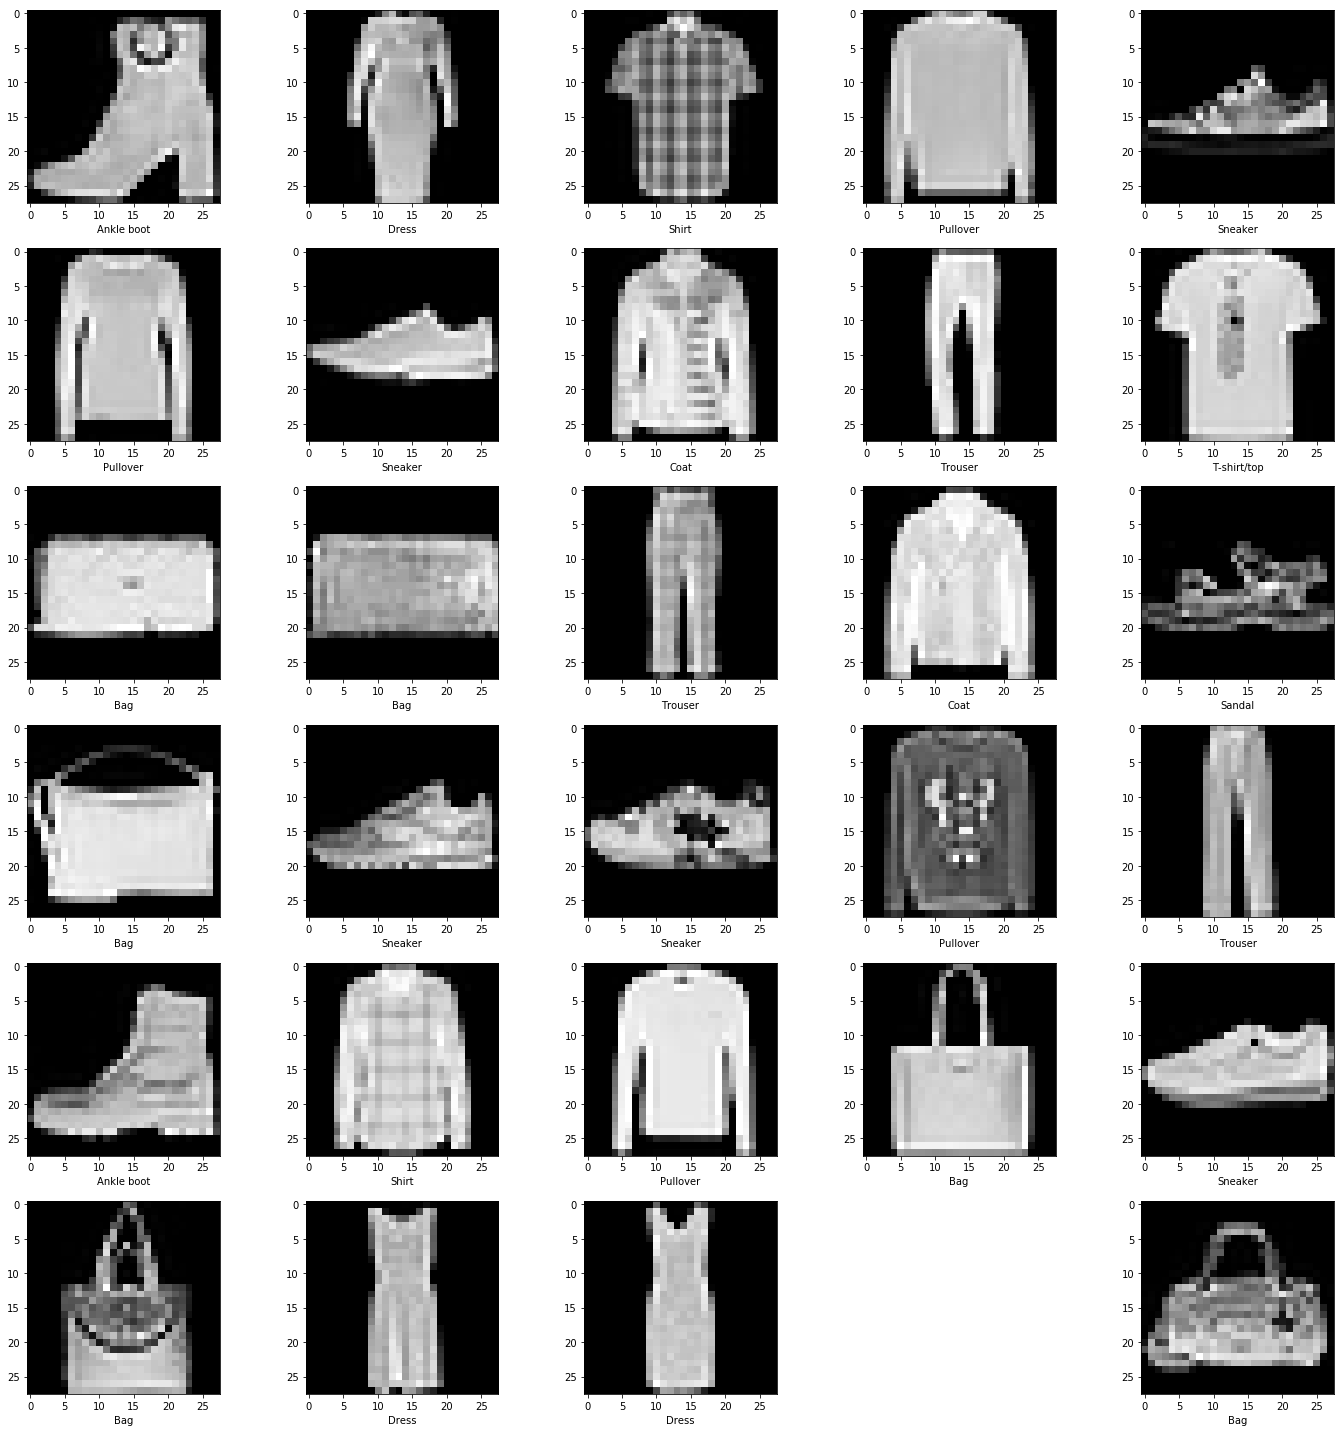

In [6]:
plt.figure(figsize=(20,20))

for i in range(30):
    plt.subplot(6, 5, i+1)
    plt.xlabel(labels_map[y_train_small[i]])
    plt.imshow(x_train_small[i], cmap='gray')
    plt.tight_layout()

Plot data images

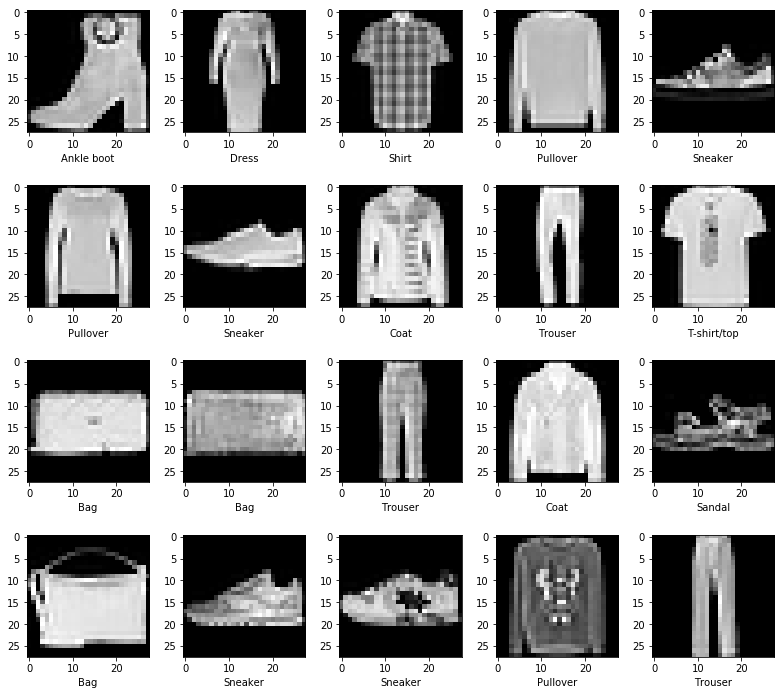

In [7]:
plt.figure(figsize=(11,10))

for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.xlabel(labels_map[y_train_small[i]])
    plt.imshow(x_train_small[i], cmap='gray')
    plt.tight_layout()

# 1. Data Converting


#### X-axis Average Coverting 

In [8]:
def conv_x_scale(data):
    return np.average(data, axis=0)

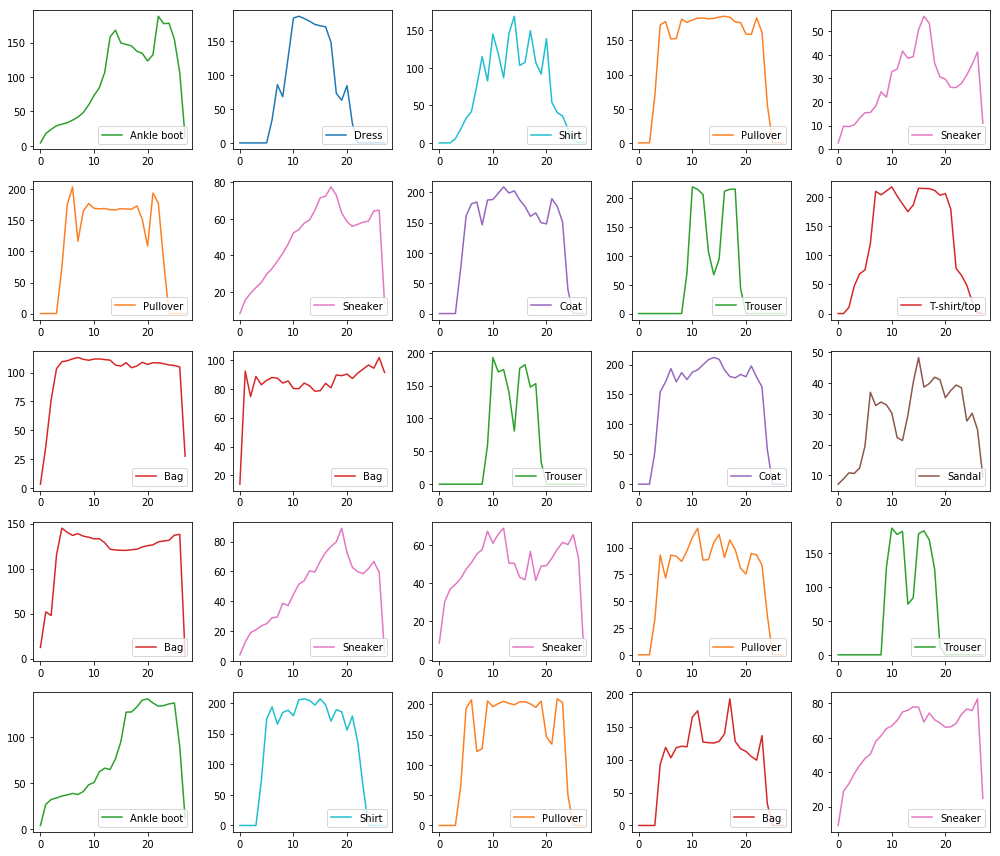

In [9]:
plt.figure(figsize=(14,12))

colors = ['#D62728','#2C9F2C','#FD7F23','#1F77B4','#9467BD',
          '#8C564A','#1FBECF','#E377C2']

for i in range(25):
    linear = conv_x_scale(x_train_small[i])
    color = colors[y_train_small[i] % len(colors)]
    plt.subplot(5, 5, i+1)
    plt.plot(linear, color=color, label=labels_map[y_train_small[i]])
    plt.legend(loc='lower right')
    plt.tight_layout()

<br>
#### Y-axis Average Converting

In [10]:
def conv_y_scale(data):
    return np.average(data, axis=1)

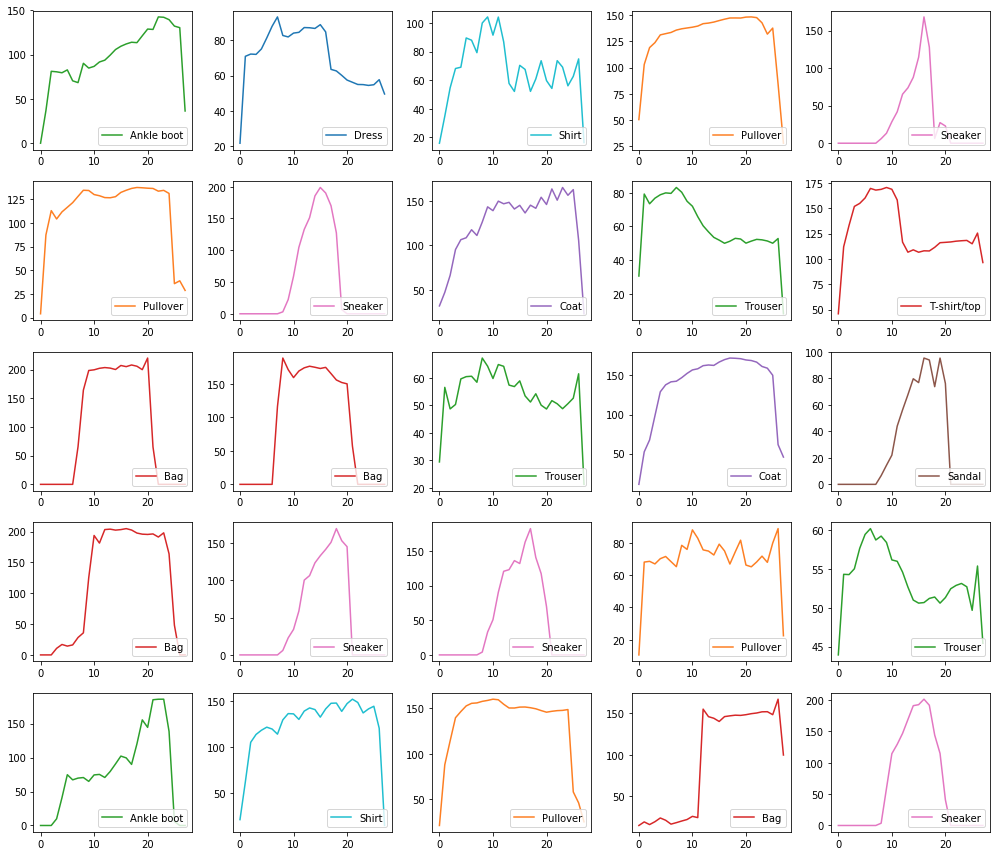

In [11]:
plt.figure(figsize=(14,12))

for i in range(25):
    linear = conv_y_scale(x_train_small[i])
    color = colors[y_train_small[i] % len(colors)]
    plt.subplot(5, 5, i+1)
    plt.plot(linear, color=color, label=labels_map[y_train_small[i]])
    plt.legend(loc='lower right')
    plt.tight_layout()

<br>
#### Four-Borders Converting

In [12]:
def conv_four_borders(data):
    black_idx = data < 63
    num = np.tile(np.arange(28), (28,1))
    
    num[black_idx] = 999
    left = np.min(num, axis=1)
    left[left == 999] = 0
    
    num[black_idx] = -999
    right = np.max(num, axis=1)
    right[right == -999] = 0
    
    num = np.tile(np.arange(28), (28, 1)).T
    
    num[black_idx] = 999
    down = np.min(num, axis=0)
    down[down == 999] = 0
    
    num[black_idx] = -999
    up = np.max(num, axis=0)
    up[up == -999] = 0
    
    return np.concatenate([up, right, down, left])

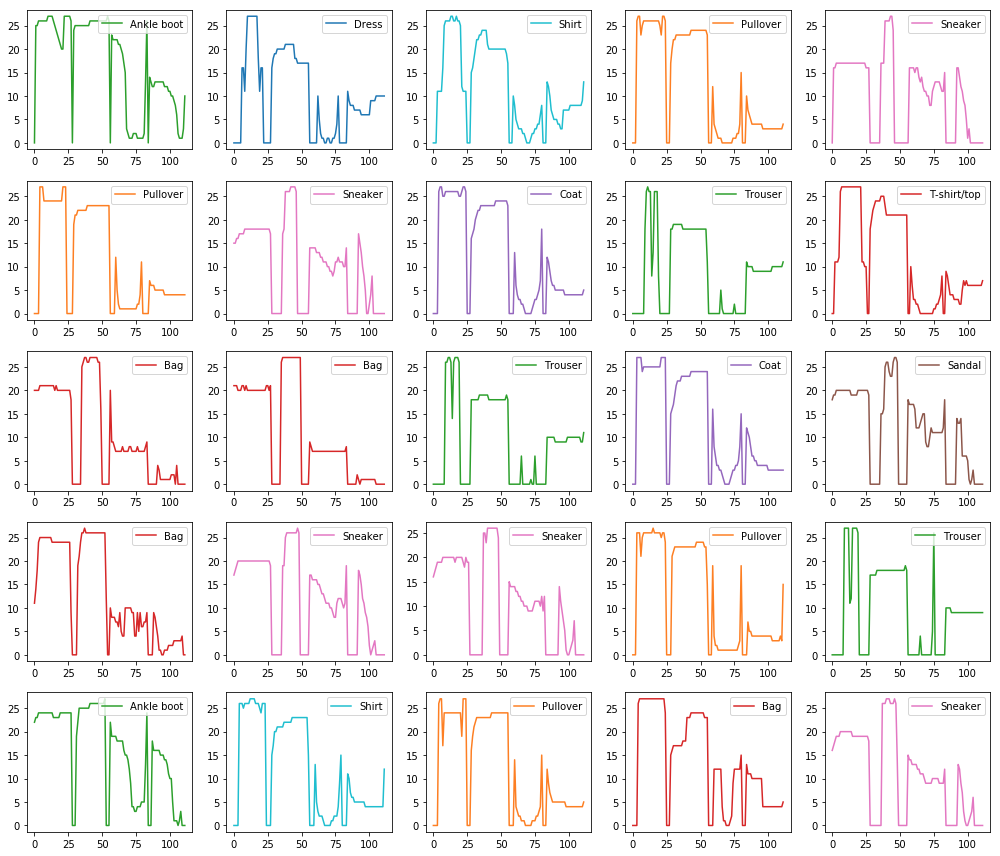

In [13]:
plt.figure(figsize=(14,12))

for i in range(25):
    four_border = conv_four_borders(x_train_small[i])
    color = colors[y_train_small[i] % len(colors)]
    plt.subplot(5, 5, i+1)
    plt.plot(four_border, color=color, label=labels_map[y_train_small[i]])
    plt.legend(loc='upper right')
    plt.tight_layout()

# 2. Model Training and Testing

#### Preprocess Data (Convert to time series)

In [14]:
def preproces(conv_fn, conv_shape):
    x_conv_train = np.zeros((x_train_small.shape[0], conv_shape))
    x_conv_test = np.zeros((x_test_small.shape[0], conv_shape))

    for i in range(x_train_small.shape[0]):
        x_conv_train[i] = conv_fn(x_train_small[i])

    for i in range(x_test_small.shape[0]):
        x_conv_test[i] = conv_fn(x_test_small[i])
        
    return x_conv_train, x_conv_test

#### Train Data & Predict Data

In [15]:
from knn_dtw.knn_dtw_clf import KnnDtw
from sklearn.metrics import classification_report, confusion_matrix

def train_and_predict(x_train, y_train, x_test):
    m = KnnDtw(n_neighbors=3, dtw_constraint='sakoe_chiba', k_constraint=10)
    m.fit(x_train, y_train)
    y_pred = m.predict(x_test)
    return y_pred

#### Display Analysis

In [16]:
def display_analysis(y_pred, y_test):
    print(classification_report(y_test, y_pred, target_names=labels))

    conf_mat = confusion_matrix(y_test, y_pred)

    fig = plt.figure(figsize=(10,10))
    width = np.shape(conf_mat)[1]
    height = np.shape(conf_mat)[0]

    res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
    for i, row in enumerate(conf_mat):
        for j, c in enumerate(row):
            if c > 0:
                plt.text(j-.2, i+.1, c, fontsize=16)

    cb = fig.colorbar(res)
    plt.title('Confusion Matrix')
    _ = plt.xticks(range(len(labels)), labels, rotation=90)
    _ = plt.yticks(range(len(labels)), labels)

<br>
### X-axis Converting

             precision    recall  f1-score   support

T-shirt/top       0.61      0.65      0.63        92
    Trouser       0.85      0.90      0.87        89
   Pullover       0.50      0.56      0.53       105
      Dress       0.52      0.86      0.65       108
       Coat       0.52      0.36      0.42       107
     Sandal       0.91      0.72      0.80       100
      Shirt       0.51      0.25      0.33        97
    Sneaker       0.70      0.81      0.75       100
        Bag       0.88      0.68      0.77        98
 Ankle boot       0.78      0.89      0.83       104

avg / total       0.67      0.67      0.66      1000



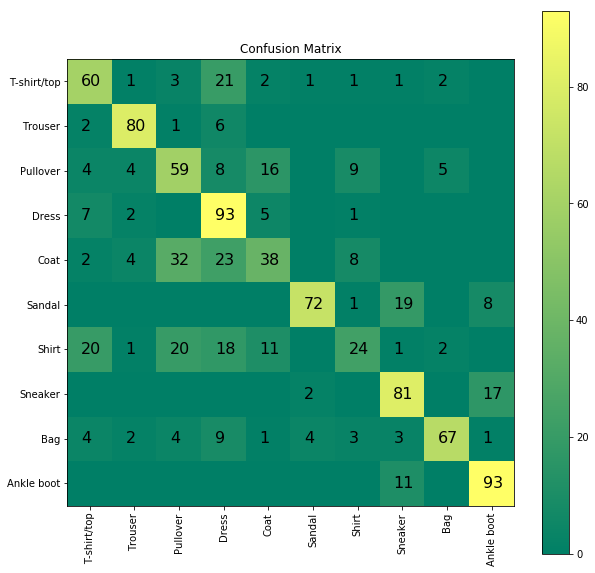

In [17]:
x_conv_train, x_conv_test = preproces(conv_x_scale, conv_shape=28)
y_pred = train_and_predict(x_conv_train, y_train_small, x_conv_test)
display_analysis(y_pred, y_test_small)

<br>
### Y-axis Converting

             precision    recall  f1-score   support

T-shirt/top       0.60      0.67      0.64        92
    Trouser       0.80      0.93      0.86        89
   Pullover       0.63      0.58      0.60       105
      Dress       0.60      0.69      0.65       108
       Coat       0.58      0.67      0.62       107
     Sandal       0.83      0.79      0.81       100
      Shirt       0.39      0.25      0.30        97
    Sneaker       0.66      0.87      0.75       100
        Bag       0.94      0.69      0.80        98
 Ankle boot       0.84      0.71      0.77       104

avg / total       0.69      0.69      0.68      1000



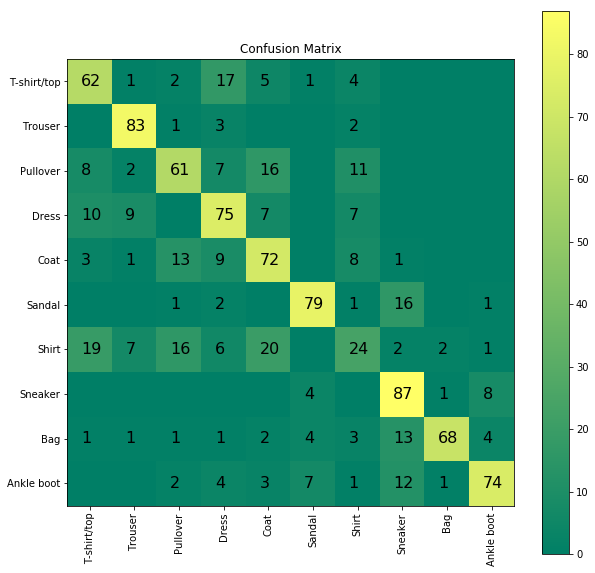

In [18]:
x_conv_train, x_conv_test = preproces(conv_y_scale, conv_shape=28)
y_pred = train_and_predict(x_conv_train, y_train_small, x_conv_test)
display_analysis(y_pred, y_test_small)

<br>
### Four-borders Converting

             precision    recall  f1-score   support

T-shirt/top       0.79      0.88      0.83        92
    Trouser       0.98      0.93      0.95        89
   Pullover       0.72      0.77      0.75       105
      Dress       0.86      0.88      0.87       108
       Coat       0.64      0.70      0.67       107
     Sandal       0.99      0.77      0.87       100
      Shirt       0.67      0.49      0.57        97
    Sneaker       0.81      0.90      0.85       100
        Bag       0.98      0.95      0.96        98
 Ankle boot       0.84      0.93      0.88       104

avg / total       0.82      0.82      0.82      1000



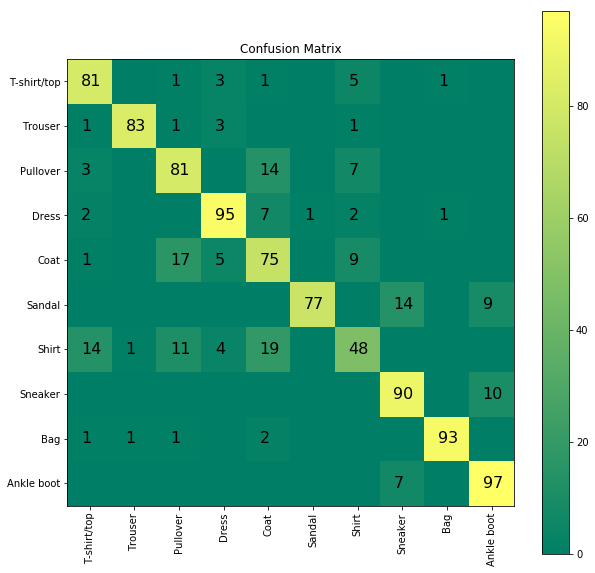

In [19]:
x_conv_train, x_conv_test = preproces(conv_four_borders, conv_shape=28 * 4)
y_pred_fb = train_and_predict(x_conv_train, y_train_small, x_conv_test)
display_analysis(y_pred_fb, y_test_small)